# q-1-5

In [1]:
import numpy as np
from numpy import log2 as log
import pandas as pd
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
eps = np.finfo(float).eps

from pylab import *
import matplotlib
import matplotlib.pyplot as plt

#### load data

In [2]:
df = pd.read_csv('train.csv')

#### get class label into Y and drop it from it from df and assign to X

In [3]:
Y = df.left
X = df.drop(['left'], axis=1)

#### perform one hot encoding 

In [4]:
Z = pd.concat([X,pd.get_dummies(X['sales'],prefix='sales')],axis=1)
Z = pd.concat([Z,pd.get_dummies(Z['salary'],prefix='salary')],axis=1)
Z = Z.drop(['sales','salary'],axis=1)

#### split data into training(80%) and testing(20%)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(Z, Y,test_size=0.2)
df1 = pd.concat([X_train, Y_train],axis=1)

#### Calculate entropy of class label

In [6]:
def class_entropy(df):
    class_label = df.keys()[-1]
    class_entropy = 0
    values = df[class_label].unique()
    for val in values:
        q = float(df[class_label].value_counts()[val])/len(df[class_label])
        class_entropy += -q*log(q)
    return class_entropy

#### calculate entropy of a feature

In [7]:
def feature_entropy(df, feature):
    class_label = df.keys()[-1]
    target_variables = df[class_label].unique()
    variables = df[feature].unique()
    entropy = 0
    for var in variables:
        ent = 0
        for t in target_variables:
            n = len(df[feature][df[feature]==var][df[class_label]==t])
            d = len(df[feature][df[feature]==var])
            q = n/(d+eps)
            ent += -q*log(q+eps)
        q2 = float(d)/len(df)
        entropy += -q2*ent
    return abs(entropy)

#### calculate IG of all features and select feature with maximum gain

In [8]:
def feature_to_select(df):
    entropy_attr = []
    gain = []
    for key in df.keys()[:-1]:
        gain.append(class_entropy(df)-feature_entropy(df,key))
    return df.keys()[:-1][np.argmax(gain)]

#### function to split data

In [9]:
def subtable(df,node,value):
    return df[df[node]==value].reset_index(drop=True)

#### helper function to calculate gain of numerical features

In [10]:
cl_entropy = class_entropy(df1)
def compute_IG(df,val,feature):
    l = df[df[feature]<val].reset_index(drop=True)
    r = df[df[feature]>=val].reset_index(drop=True)
    l_entropy = class_entropy(l)
    r_entropy = class_entropy(r)
    return cl_entropy - ( (float(len(l))/(len(df)+eps)*l_entropy) + (float(len(r))/(len(df)+eps)*r_entropy) )  

#### calculate the split point for numerical feature

In [11]:
def split_num_feature(data,cl_label,feature):
    
    max_ig = 0
    max_split = None
    pair = pd.concat([data,cl_label],axis=1)
    pair = pair.sort_values(by=feature).reset_index()
    for i in xrange(len(data)-1):
        if pair['left'][i]!=pair['left'][i+1]:
            ig = compute_IG(pair,float(pair[feature][i] + pair[feature][i+1])/2, feature)
            if ig > max_ig:
                max_ig = ig
                max_split = float(pair[feature][i] + pair[feature][i+1])/2
    return max_split


#### change dataframe from numerical to 0 and 1 according to split point

In [12]:
def change_df(df,val,feature):
    df.loc[df[feature]<val,feature]=0
    df.loc[df[feature]>=val,feature]=1
    return

#### calculate the split point for all numerical features and get split values for all in a dictionary

In [13]:
numerical_attributes=['number_project','last_evaluation', 'satisfaction_level','average_montly_hours','time_spend_company']
split_values={}

for at in numerical_attributes:
    split = split_num_feature(df1[at],df1['left'],at)
    split_values[at]=split
print split_values



{'satisfaction_level': 0.46499999999999997, 'last_evaluation': 0.575, 'average_montly_hours': 274.5, 'time_spend_company': 3.0, 'number_project': 2.5}


#### preprocess data to perform prediction

In [14]:
def preprocess(df,split_values):
    for at,data in split_values.iteritems():
        change_df(df,data,at)

In [15]:
preprocess(df1,split_values)

#### node of decision tree

In [16]:
class Node:
    def __init__(self,feature,positive=0,negative=0):
        self.feature=feature
        self.positive=positive
        self.negative=negative
        self.left=None
        self.right=None

#### function that generates the tree

In [17]:
def build_Tree(df,d):
    if len(df.columns)==1 or d==0:
        return None
    
    split_node = feature_to_select(df)
    root = Node(split_node)
    root.positive=len(df[df['left']==1]['left'])
    root.negative=len(df[df['left']==0]['left'])
    
    subtable_left = subtable(df,split_node,0)
    subtable_right = subtable(df,split_node,1)
    
    subtable_left = subtable_left.drop(split_node,axis=1)
    subtable_right = subtable_right.drop(split_node,axis=1)
    
    clValue_left,counts_left = np.unique(subtable_left['left'],return_counts=True)
    clValue_right,counts_right = np.unique(subtable_right['left'],return_counts=True)
    
    if len(counts_left)>1:
        root.left=build_Tree(subtable_left,d-1)
    
    if len(counts_right)>1:
        root.right=build_Tree(subtable_right,d-1)
        
    return root

#### prediction function

In [18]:
def rec_predict(df,root,prediction):
    if root==None:
        return None

    try:
        if root.right==None and root.left==None:
            prediction.append(1 if root.positive>root.negative else 0)
            return

        if root.right==None and df[root.feature]==1:
            prediction.append(1 if root.positive>root.negative else 0)
            return

        if root.left==None and df[root.feature]==0:
            prediction.append(1 if root.positive>root.negative else 0)
            return

        if df[root.feature]==0:
            rec_predict(df,root.left,prediction)
        else:
            rec_predict(df,root.right,prediction)
    except KeyError:
        if root.left==None:
            prediction.append(1 if root.positive>root.negative else 0)
            return
        rec_predict(df,root.left,prediction)
            
def predict(df,root,prediction):
    for col,row in df.iterrows():
        rec_predict(row,root,prediction)

In [19]:
pd.options.mode.chained_assignment = None
preprocess(X_train,split_values)
preprocess(X_test,split_values)

In [20]:
error_train = []
error_test = []

for i in xrange(2,21,2):
    root = build_Tree(df1,i)
    prediction_train=[]
    prediction_test=[]
    
    tr_cp=X_train.copy(deep=True)
    ts_cp=X_test.copy(deep=True)
    
    predict(tr_cp,root,prediction_train)
    predict(ts_cp,root,prediction_test)
    
    error_train.append(1-accuracy_score(Y_train,prediction_train))
    error_test.append(1-accuracy_score(Y_test,prediction_test))

Text(0.5,1,'depth vs error')

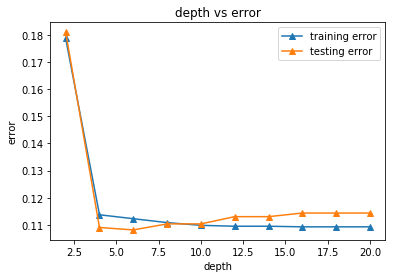

In [22]:
x_axis = [i for i in xrange(2,21,2)]
fig,ax = plt.subplots()
ax.plot(x_axis,error_train, label="training error",marker="^")
ax.plot(x_axis,error_test,label="testing error",marker="^")
ax.legend()
ax.set_xlabel("depth")
ax.set_ylabel("error")
ax.set_title("depth vs error")


#### perform prediction with our model

#### perform prediciton with inbuilt model

#### Testing from file